# Marvel Superhero Analysis

**Scraping from the Wikipedia API to Understand the History and Breakdown of Marvel Superheroes**

*A project by Gerard Goucher*

**Please run the following code beforehand** in your terminal to ensure all necessary Python modules are installed on your computer.

In [ ]:
pip install -r requirements.txt

####  Part 1: Collecting Basic Statistics 

In order to properly analyze trends regarding Marvel Superheroes and Supervillains, we must first generate lists of all of them. 
>*Note: Some characters aren't so clearly defined by their hero or villain statuses. Generally, this is because at some point or another, they have switched roles. We will make determinations regarding their statuses in **Part 4**.*

In [1]:
import json
import requests as rq

def get_data(link): #
    '''
    This function recursively goes through the data of each page of a category, finding the cmcontinue value.
    I utilize recursion to ensure all pages of a category list are ran through.
    The formatting requested of the Wikipedia API will be detailed below.
    '''
    data = rq.get(link).json()
    if 'continue' in data:
        return data['query']['categorymembers'] + get_data(link + '&cmcontinue=' + data['continue']['cmcontinue'])
    else:
        return data['query']['categorymembers']
  

def name_generator(link):
    '''
    This function takes the data from the category pages we scraped from and cleans it up slightly, ensuring that
    we're only including information on cahracters and not inaccurately looking at other category or list pages.
    '''
    data = get_data(link)
    final_list = []
    for i in range(len(data)):
        if 'category' not in data[i]['title'].lower() and 'list' not in data[i]['title'].lower():
            final_list.append(data[i]['title'])
    return final_list


'''
Below, we see the function calls to get our list of heroes and villains. 
We see the requests made of the API, which I will break down now.

format = json - The JSON format is chosen in order for us to be able to parse through the data more easily. 
Key, value pairs are easy to look through with Python.

action = query - Allows us to access data from the API

cmtitle = ... - Used to open category page.

cmlimit = max - Set to max so we have to run the get_data function as little as possible

list = categorymembers - Returns data points that contain the individual page titles within a category, giving us the names of superheroes.
'''


villain_list = name_generator("https://en.wikipedia.org/w/api.php?format=json&action=query&cmtitle=Category:Marvel_Comics_supervillains&cmlimit=max&list=categorymembers")
hero_list = name_generator("https://en.wikipedia.org/w/api.php?format=json&action=query&cmtitle=Category:Marvel_Comics_superheroes&cmlimit=max&list=categorymembers")
        
print('There are ' + str(len(villain_list)) + ' supervillains in the Marvel universe.')
print('There are ' + str(len(hero_list)) + ' superheroes in the Marvel universe.')


# Determining the amount of overlap

total_number = set(hero_list) | set(villain_list) # Creates a set containing aggregate amount of marvel characters.

shared_characters = len(hero_list) + len(villain_list) - len(total_number) # Determines the overlap between the two, or the ambiguous charcters.
print('There are ' + str(shared_characters) + ' overlapping (ambiguous) characters.')


'''
The following calculation finds amount of overlap/amount of union. 
This returns the Jaccard Index, or the the coefficient of ambiguyous characters.
''' 
jac_similarity = shared_characters / len(total_number) 
print("The Jaccard Index is " + str(jac_similarity))

There are 1034 supervillains in the Marvel universe.
There are 789 superheroes in the Marvel universe.
There are 146 overlapping (ambiguous) characters.
The Jaccard Index is 0.08706022659511031


#### Part 2: Storing Data

Since there are obviously huge amounts of supervillains and superheroes, it is necessary to run the following code to store markups on your hard drive instead of on the the RAM. This data will be stored in subdirectories in your current working directory. 

In [2]:
import os

path = os.getcwd()

def new_directory(new_directory, desired_path):
    '''This function easily creates new directories'''
    new_path = '/' + new_directory
    try:
        os.mkdir(desired_path + new_path)
    except FileExistsError:
        print("Directory %s already exists. \n" % (desired_path + new_path))
    except OSError:
        print("New directory creation for %s failed. \n" % (desired_path + new_path))
    else:
        print("Created new directory %s. \n" % (desired_path + new_path))

        
        
new_directory('marvel_markups', path) #Creates parents folder for subdirectories

parent_directory = path + '/marvel_markups'


## Creates subdirectories
new_directory('heroes', parent_directory)
new_directory('villains', parent_directory)
new_directory('ambiguous', parent_directory)

Directory /Users/gerardgoucher/Desktop/marvel_superhero_project/marvel_markups already exists. 

Directory /Users/gerardgoucher/Desktop/marvel_superhero_project/marvel_markups/heroes already exists. 

Directory /Users/gerardgoucher/Desktop/marvel_superhero_project/marvel_markups/villains already exists. 

Directory /Users/gerardgoucher/Desktop/marvel_superhero_project/marvel_markups/ambiguous already exists. 



The following code extracts each character's markup into their relevant subdirectors. 
> **NOTE: THIS WILL TAKE A LONG TIME TO RUN**

In [3]:
#Now, we extract the markups into our new subdirectories

'''
The following code finds the total list of characters from the union of sets of heroes and villains above.
Additionally, we sort the characters for neatness.
'''
total_list = list(total_number)
total_list.sort()

#The following is the function that will extract the markup


os.chdir(parent_directory)


def markup_extraction(name):
    '''
    This function finds the markup for an individual character. 
    '''
    if os.path.exists(name + '.txt') is False:
        #The following step is necessary to get us to use the latest page revision
        page_id_source = rq.get('https://en.wikipedia.org/w/api.php?format=json&action=parse&page=' + name).json()
        page_id = page_id_source['parse']['pageid']
        #Using the Page ID, we are able to find the markup for the page and download it.
        #The following API request is altered for each individual charcter rather than the category lists.
        imp = rq.get('https://en.wikipedia.org/w/api.php?format=json&action=query&titles=' + name + '&prop=revisions&rvprop=content').json()
        to_write = imp['query']['pages'][str(page_id)]['revisions'][0]['*']
        #The following steps write the new files
        page = open(name + ".txt", "w+")
        page.write(to_write)
        page.close()

        
def write_files(list):
    for i in range(len(list)):
        #The following step is done in order for the names to be inputted into the directory.
        if ' / ' in total_list[i]:
            total_list[i] = total_list[i].replace(' / ','_')
            
        if list[i] in hero_list and list[i] in villain_list:
            os.chdir(parent_directory + '/ambiguous')
            markup_extraction(list[i])
        elif list[i] in hero_list:
            os.chdir(parent_directory + '/heroes')
            markup_extraction(list[i])
        elif list[i] in villain_list:
            os.chdir(parent_directory + '/villains') 
            markup_extraction(list[i])
    print("Files Written!")

# NOTE - THIS WILL TAKE A VERY LONG TIME TO RUN
write_files(total_list)



os.chdir(parent_directory)

Files Written!


#### Part 3: Data Visualization and Exploration

Now that we have taken all of our data from the Wikipedia API and have sufficiently cleaned it, we will explore it more using some visualization tools. First, we will be creating a PMF of page lengths for each subcategory via a histrogram.

The following step allows us to loop through a directory and open all the text files 
and finds the length of each. This will be useful for future analysis.

In [4]:
def page_lengths(pathname):
    '''This function loops through each of the files in a folder containing text files and finds their legnths'''
    output_list = []
    nameless_lengths = []
    
    character_list = os.listdir(pathname)
    os.chdir(pathname)
    for i in range(len(character_list)):
        page = open(character_list[i]).read()
        length = len(str(page))
        # since the .txt extension is included, we slice off the ends
        output_list.append((character_list[i][:-4], length))
        #for our next histogram
        nameless_lengths.append(length)
        
    return (output_list, nameless_lengths)
    
os.chdir(parent_directory)

villain_length = page_lengths(parent_directory + '/villains')
ambiguous_length = page_lengths(parent_directory + '/ambiguous')
heroes_length = page_lengths(parent_directory + '/heroes')

Now, we will compare page lengths between the three categories of marvel characters. This should offer some interesting trends to analyze. 

Text(0.5, 0, 'Page Length')

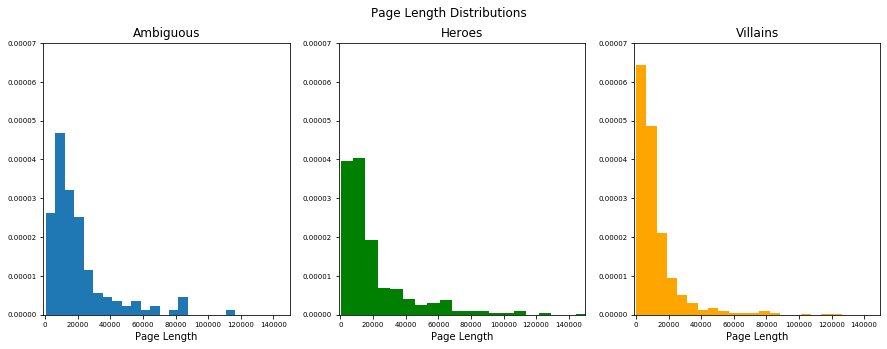

In [6]:
import matplotlib.pyplot as plt

fig, (axs1, axs2, axs3) = plt.subplots(1, 3) #I created a 3 histograms side by side to visualize the density of page lengths.
fig.set_size_inches(15, 5)
fig.suptitle("Page Length Distributions")
axs1.hist(ambiguous_length[1],density=True,bins=20)
axs1.set_title("Ambiguous")
axs1.set(xlim=(-1000, 150000), ylim=(0, .00007))
axs1.tick_params(labelsize=7)
axs1.set_xlabel("Page Length")

axs2.hist(heroes_length[1],density=True,bins=20,color='green')
axs2.set_title("Heroes")
axs2.set(xlim=(-1000, 150000), ylim=(0, .00007))
axs2.tick_params(labelsize=7)
axs2.set_xlabel("Page Length")

axs3.hist(villain_length[1],density=True,bins=20,color='orange')
axs3.set_title("Villains")
axs3.set(xlim=(-1000, 150000), ylim=(0, .00007))
axs3.tick_params(labelsize=7)
axs3.set_xlabel("Page Length")


Looking at the histograms above, we can notive some interesting trends. The hero markups are, in general, longer than the villain markups. When thinking about the films or comics, this makes sense given the commonly one-dimensional stories of villains. The ambiguous markups, however, aren't so easily differentiated. This makes sense, given their questionable defintions.

Now, we will look at the timelines of these characters debuts, hoping to gain some insight about Marvel comics over time. We will use the regular expression module to do this.

In [7]:
import re

def page_debuts(pathname): # similar to the page_lengths function above, just adjusted for RE usage to find debuts.
    '''This function loops through each of the files in a folder containing text files and finds their debuts'''
    output_debuts = {}
    nameless_debuts = []
    
    character_list = os.listdir(pathname)
    os.chdir(pathname)
    for i in range(len(character_list)):
        page = open(character_list[i]).read()
        try:
            '''
            The regular expressions function below works in a variety of ways.
            
            Looking at the nested findall call within the other findall call, we see that
            I am first looking for a line with the word "debut" in it, then choosing the first line
            (since debut information is early in the wikipedia markup). Then, we apply the findall
            function AGAIN on this line that we've found. the \d{4}\ finds 4 digit numbers
            in this new line, and we choose the first output here (an arbitrary choice), as there
            can be multiple depending on whether or not these characters are in comics, films, or other mediums.
            Then, the result is taken as an integer, so that it is easier to visualize later.
            '''
            debut = int(re.findall(r"\d{4}\)", re.findall(r"debut.+?\n", page)[0])[0][:-1])
        #some debuts aren't included in a characters markup, we will choose to not include them in our visualization.
        except: 
            debut = 'none'
        if debut != 'none':   
            # since the .txt extension is included, we slice off the ends
            output_debuts[character_list[i][:-4]] = debut
            #for our next histogram
            nameless_debuts.append(debut)
        
    return (output_debuts, nameless_debuts)

villain_debuts = page_debuts(parent_directory + '/villains')
ambiguous_debuts = page_debuts(parent_directory + '/ambiguous')
heroes_debuts = page_debuts(parent_directory + '/heroes')
    
os.chdir(parent_directory)

Now, we will compare debut years between the three categories of marvel characters. This should offer some interesting trends to analyze. 

Text(0.5, 0, 'Years')

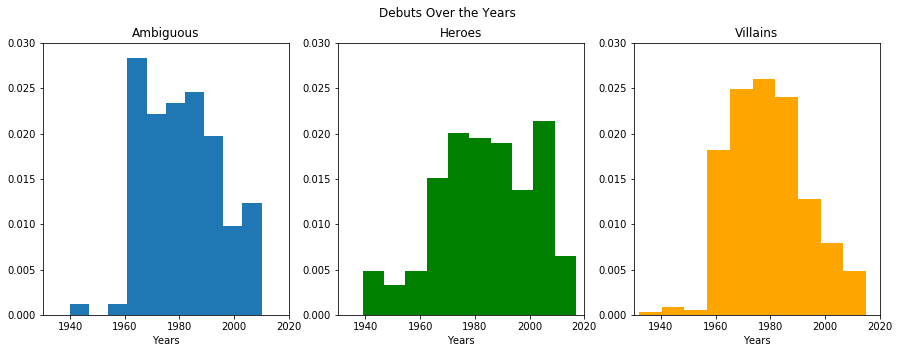

In [8]:
import numpy as np

fig, (axs1, axs2, axs3) = plt.subplots(1, 3) #I created a 3 histograms side by side to visualize the debuts.
fig.set_size_inches(15, 5)
fig.suptitle("Debuts Over the Years")
axs1.hist(ambiguous_debuts[1],density=True)
axs1.set_title("Ambiguous")
axs1.set(xlim=(1930, 2020), ylim=(0, .03)) # axes set for all 3 to normalize
axs1.set_xlabel("Years")

axs2.hist(heroes_debuts[1],density=True,color='green')
axs2.set_title("Heroes")
axs2.set(xlim=(1930, 2020), ylim=(0, .03))
axs2.set_xlabel("Years")

axs3.hist(villain_debuts[1],density=True,color='orange')
axs3.set_title("Villains")
axs3.set(xlim=(1930, 2020), ylim=(0, .03))
axs3.set_xlabel("Years")

Interestingly, with the above visualizations, we see that a spike in character debuts during and after the 1960s. What's more is that there is a massive spike of villains and ambiguous characters coming out during and after the 1960s, a significant spike considering that this was around the peak of the Cold War. While I am by no means a comic book expert, this is definitely an interesting spike and potentially could explain the rise of these villains. After looking into the history of Marvel as an entity, I learned that this is when what was at the time Atlas Magazines was rebranded to Marvel Comics as we know it today. 

#### Part 4: Ambiguous Character Predictions

Now that we've explored our data a bit, it's clear that a useful application of ML would be to classify our ambiguous characters into hero or villain categories. We will approach this in two ways, first by looking at team alliances and training a Naive Bayes classifier on this information to predict ambiguous character categories. After this, we will do a TF-IDF scoring measure on the text from our character markups to, again, predict ambiguous character categories. 

First, we are going to make hero or villain predictions based upon team alliances. First, we are going to make a list of all the teams, which will allow us to make an array of team alliances to train our Naive Bayes classifier on.

In [9]:
#Finds the alliances for all Marvel characters and returns as a list
def get_alliances(char, faction=None):
    """Return list of alliances for Marvel character."""
    
    if faction is None:
        for faction in ["heroes", "ambiguous", "villains"]:
            faction_chars = [c[:-4] for c in os.listdir(parent_directory + "/%s" % faction)]
            if char in faction_chars:
                break
    
    # Load character markup
    with open(parent_directory + "/%s/%s.txt" % (faction, char)) as fp:
        markup = fp.read()

    # Get alliance field. NOTE: THE FOLLOWING TWO RE COMMANDS HAVE BEEN OBTAINED FROM AN INSTRUCTOR.
    alliances_field = re.findall(r"alliances[\w\W]+?\|.+=", markup)
    if alliances_field == []:
        return []

    # Extract teams from alliance field
    return [t[2:-1] for t in re.findall(r"\[\[.+?[\]\|]", alliances_field[0][10:])]

#Making a list of all characters
Characters = []

for faction in ["heroes", "ambiguous", "villains"]:
    faction_chars = [c[:-4] for c in os.listdir(parent_directory + "/%s" % faction)]
    for char in faction_chars:
        Characters.append(char)

#Making a list of all Teams
Teams = []
Teams = set(Teams)
for character in Characters:
    alliances = get_alliances(character)
    for alliance in alliances:
        Teams.add(alliance)

all_teams = sorted(set(Teams))

Now that we have all of our teams, we can loop through our characters and generate an array of character team involvements.

In [13]:
def vec_Teams(x):
    '''Making a list of 0 and 1s to represent individual characters involvement with teams.'''
    alliances_vector = []
    alliances = get_alliances(x)
    for team in all_teams:
        if team in alliances:
            alliances_vector.append(1)
        if team not in alliances:
            alliances_vector.append(0)
    return alliances_vector

length = len(all_teams)


#taking out ambiguous characters, this makes it easier for us to create our target array
HV = []

##need to add the heaores wihtout alliances 
for faction in ["heroes", "villains"]:
    faction_chars = [c[:-4] for c in os.listdir(parent_directory + "/%s" % faction)]
    for char in faction_chars:
        HV.append(char)

#making the team alliance matrix   
team_Alliance_Matrix = []
for character in HV:
    alliance_matrix = vec_Teams(character)
    team_Alliance_Matrix.append(alliance_matrix)

team_Alliance_Matrix_array = np.array(team_Alliance_Matrix)

#making list of heroes, so that we can create our target array. 
Heroes = []

for faction in ["heroes"]:
    faction_chars = [c[:-4] for c in os.listdir(parent_directory + "/%s" % faction)]
    for char in faction_chars:
        Heroes.append(char)

        
#making list of ambiguous characters, so we can eventually predict their alliances
Ambiguous = []
for character in Characters:
    if character not in HV:
        Ambiguous.append(character)

        
#making the target array  
Target = []
HV = sorted(HV)

for c in HV:
    if c in Heroes: 
        Target.append(1)
    #signifiying villains
    else: 
        Target.append(0)

Now that we have our training and target arrays completed, we can set up our Naive bayes classifier. We will utilize a Bernoulli Naive Bayes Classifier, as our data is represented in a binary context. This probabilitistic classifier is useful because it allows us to visualize the level of "heroness" that each character possesses, giving us a probability that an ambiguous character is a hero rather than just spitting out that a character is a hero or villain. We will use the binary approach later with the TF-IDF analysis of these characters.

In [67]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split

#Creating our training and testing data
X_train, X_test, y_train, y_test = train_test_split(team_Alliance_Matrix_array, Target)

#Creating our model
model = BernoulliNB()

#Fitting model with our training data
model.fit(X_train, y_train)

#Determining accuracy
train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)

In [68]:
print('The accuracy the model gives us for the training set is %s.' % train_accuracy)
print('The accuracy the model gives us for the testing set is %s.' % test_accuracy)

The accuracy the model gives us for the training set is 0.6986644407345576.
The accuracy the model gives us for the testing set is 0.5675.


Now, we'll use the classifier on our ambiguous data. We'll use the classifier to find probabilities of characters being heros or villains.

In [69]:
Ambiguous = sorted(Ambiguous)

team_Alliance_AmbigMatrix = []

for character in Ambiguous:
    a_matrix = vec_Teams(character)
    team_Alliance_AmbigMatrix.append(a_matrix)
 
team_Alliance_AmbigMatrix = np.array(team_Alliance_AmbigMatrix)


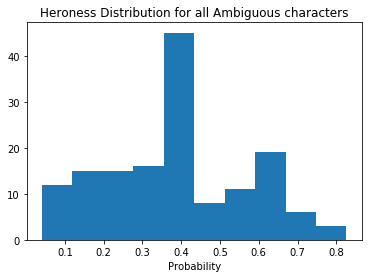

In [70]:
#using the model to estimate the probability that each character is a hero or villian 
ambig_predict = model.predict_proba(team_Alliance_AmbigMatrix)

villian_prob = []
hero_prob = []

for elem in ambig_predict:
    villian_prob.append(elem[0])
    hero_prob.append(elem[1])

#villian_prob = the probability that each chracter is a villain     
#hero_prob = the probability that each chracter is a hero  

#visualizing the "heroness" distribution for all ambiguous characters 
plt.hist(hero_prob)
plt.title("Heroness Distribution for all Ambiguous characters")
plt.xlabel("Probability")
plt.show()

Looking at the result, we see that this analysis yields a more unsure prediction for ambiguous alliances, as probabilites are clustered in the middle. We will now utilize a TF-IDF analysis and try to see if that will remove some of the ambiguity we've noticed. Additionally, instead of using a Naive Bayes classifier, we will use a LinearSVC classifier. This allows us to utilize the many more features the TF-IDF gives us in a way conceptually similar to line of best fit, called a hyperplane. 

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tf_transformer(characters):
    '''takes data and transformers it along TF-IDF lines for further transformation'''
    
    tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1, 2), stop_words='english')
    
    analyze_list = []
    types = []
    
    for character in characters:
        if character in Heroes:
            with open(parent_directory + "/heroes/%s.txt" % character) as fp:
                markup = fp.read()
            analyze_list.append(markup)
            types.append(1)
        else:
            with open(parent_directory + "/villains/%s.txt" % character) as fp:
                markup = fp.read()
            analyze_list.append(markup)
            types.append(0)
            
    final_features = tfidf.fit_transform(analyze_list).toarray()
    
    return (final_features, types, tfidf)

In [57]:
tf_transformed = tf_transformer(HV)

In [78]:
from sklearn.svm import LinearSVC

X_train, X_test, y_train, y_test = train_test_split(tf_transformed[0], tf_transformed[1])

model = LinearSVC()
model.fit(X_train, y_train)
train_accuracy = model.score(X_train, y_train)
test_accuracy = model.score(X_test, y_test)

In [79]:
print('The accuracy the model gives us for the training set is %s.' % train_accuracy)
print('The accuracy the model gives us for the testing set is %s.' % test_accuracy)

The accuracy the model gives us for the training set is 1.0.
The accuracy the model gives us for the testing set is 0.9625.


As we can see, training the LinearSVC classifier on the TF-IDF array gives us incredibly accuracy. We will now apply this model on the ambiguous data.

In [87]:
def ambig_scores(characters):
    '''takes a character list input and returns transformed array to above TF-IDF'''
    
    to_transform = []
    
    for character in characters:
        with open(parent_directory + "/ambiguous/%s.txt" % character) as fp:
            markup = fp.read()
        to_transform.append(markup)
        
    transformation = tf_transformed[2].transform(to_transform)
    
    pred = model.predict(transformation)
    
    heroes = 0
    villains = 0
    
    for entry in pred:
        if entry == 1:
            heroes += 1
        else:
            villains += 1
    
    return (heroes, villains)

In [88]:
ambig_predict = ambig_scores(Ambiguous)

In [92]:
print('The LinearSVC model predicts that there are %s heroes.' % ambig_predict[0])
print('The LinearSVC model predicts that there are %s villains.' % ambig_predict[1])

The LinearSVC model predicts that there are 60 heroes.
The LinearSVC model predicts that there are 90 villains.


#### Part 5: Conclusions

Notably, we aren't able to find the probabilities of an ambiguous character being a hero or villain using the LinearSVC classifier. In the future, it may be useful to explore other classifiers, ones which don't sacrifice accuracy for being able to show predictions. Additionally, in the future, I would like use the visualization and ML tools utilized above on actual marvel texts and films to try to get directly to the source of information. Furthermore, many of the characters in the marvel universe have been around for a long time, so using data science tools to analyze them over time could be fascinating. 